In [1]:
import torch
import numpy as np
from torch import nn, Tensor

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, RandomSampler
from torchvision.datasets import MNIST
import os
import time

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
root = "./datasets"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = MNIST(root, 
                      train=True, 
                      download=True,
                      transform=transform)

test_dataset = MNIST(root, 
                     train=False, 
                     download=True,
                     transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)


dataset = []
labels = []
for x, y in train_loader:
    dataset.append(x.reshape(-1, 28*28))
    labels.append(Tensor(y).view(-1, 1))
dataset = torch.cat(dataset, dim=0).to(device)
labels = torch.cat(labels, dim=0).to(device)
dataset.shape, labels.shape

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.32MB/s]


(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [3]:
# class Flow(nn.Module):
#     def __init__(self, dim, h):
#         super().__init__()
#         self.dim = dim

#         self.encoder = nn.Sequential(
#             nn.Linear(dim, dim//4), nn.ELU(),
#             nn.Linear(dim//4, dim//16), nn.ELU(),
#             nn.Linear(dim//16, h-1)
#             # nn.Conv2d(1, 4, 6), nn.ELU(),
#             # nn.Conv2d(4, 16, 5), nn.ELU(),
#             # nn.Conv2d(4, 4, 4),
#             # nn.Flatten()
#         )

#         self.net = nn.Sequential(
#             nn.Linear(h, h), nn.ELU(),
#             nn.Linear(h, h), nn.ELU(),
#             nn.Linear(h, h), nn.ELU(),
#             nn.Linear(h, h), nn.ELU(),
#             nn.Linear(h, h)
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(h, h), nn.ELU(),
#             nn.Linear(h, h), nn.ELU(),
#             nn.Linear(h, dim)
#         )
    
#     def forward(self, t, x):
#         x = self.encoder(x)
#         # print(x.shape, t.shape)
#         # print(torch.cat((t, x), dim=-1).shape)
#         h = self.net(torch.cat((t, x), dim=-1))
#         h = self.decoder(h)
#         return h
    
#     def step(self, x, t_start, t_end):
#         t_start = t_start.view(1, 1).expand(x.shape[0], 1)
#         t_end = t_end.view(1, 1).expand(x.shape[0], 1)
        
#         t_mid = (t_end + t_start) / 2
#         x_mid = x + self.forward(t=t_start, x=x) * (t_mid - t_start)
#         return  x + self.forward(t=t_mid, x=x_mid) * (t_end - t_start)

# model = Flow(784, 128)
# n = 1
# x_0 = torch.randn(n, 784)
# t = torch.rand(n, 1)
# x_t = model(t, x_0).view(28, 28)
# plt.imshow(x_t.detach().cpu().numpy())

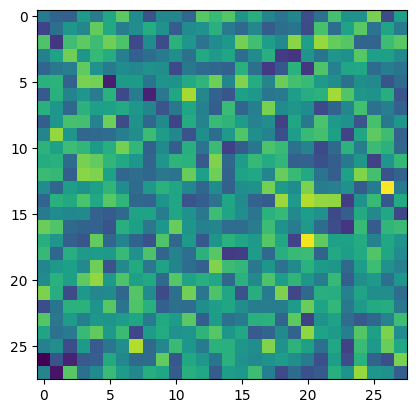

In [4]:
class Flow(nn.Module):
    def __init__(self, dim, h):
        super().__init__()
        self.dim = dim
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )
    
    def forward(self, t, x):
        return self.net(torch.cat((t, x), dim=-1))
    
    def step(self, x, t_start, t_end):
        t_start = t_start.view(1, 1).expand(x.shape[0], 1)
        t_end = t_end.view(1, 1).expand(x.shape[0], 1)
        
        t_mid = (t_end + t_start) / 2
        x_mid = x + self.forward(t=t_start, x=x) * (t_mid - t_start)
        return  x + self.forward(t=t_mid, x=x_mid) * (t_end - t_start)

model = Flow(784, 128).to(device)

x_0 = torch.randn(1, 784).to(device)
t = torch.rand(len(x_0), 1).to(device)
x_1 = model(t, x_0).view(28, 28)
plt.imshow(x_1.detach().cpu().numpy())

In [5]:
def train(model, optimizer, loss_fn, epochs=2000, show_every=None, show_loss=False):
    model.train()
    losses = []
    
    # x_0 = [5*torch.cat([torch.tensor([np.cos(2 * np.pi * k / 10), np.sin(2 * np.pi * k / 10)]), 
    #                   torch.zeros(28*28 - 2)], dim=0).expand(len(dataset) // 10, 28*28) for k in range(1, 11)]
    # x_0 = torch.cat(x_0, dim=0).to(torch.float32).to(device)
    
    if not show_every is None:
        show_loss = True
    
    for i in range(epochs):
        s = time.time()
        x_1 = dataset
        x_0 = torch.randn_like(x_1).to(device)
        # x_0 += 0.3 * torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0], 1).to(device)

        x_t = (1 - t) * x_0 + t * x_1
        dx_t = x_1 - x_0

        v = model(t=t, x=x_t)
        loss = loss_fn(v, dx_t)
        losses.append(loss.detach().item())

        if show_loss and i % show_every == 0:
            print(f"Epoch: {i}, Loss: {losses[i]:.4f}, Time: {(time.time() - s):.2f}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses


Epoch: 0, Loss: 2.0062, Time: 0.13
Epoch: 500, Loss: 1.3223, Time: 0.02
Epoch: 1000, Loss: 1.3036, Time: 0.02
Epoch: 1500, Loss: 1.2992, Time: 0.02
Epoch: 2000, Loss: 1.2951, Time: 0.02
Epoch: 2500, Loss: 1.2934, Time: 0.02
Epoch: 3000, Loss: 1.2928, Time: 0.02
Epoch: 3500, Loss: 1.2930, Time: 0.02
Epoch: 4000, Loss: 1.2933, Time: 0.02
Epoch: 4500, Loss: 1.2905, Time: 0.02


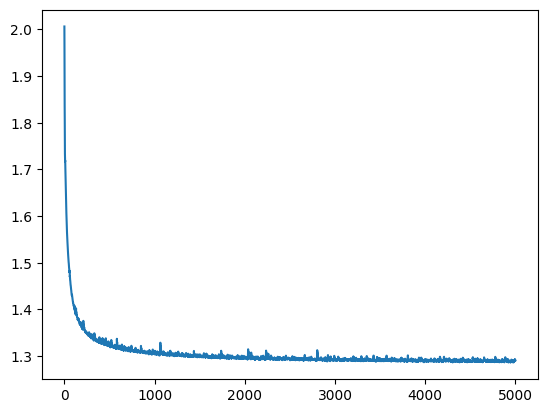

In [6]:
flow = Flow(28*28, 64).to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
loss = torch.nn.MSELoss()
losses = train(flow, optimizer, loss, epochs=5000, show_every=500)
plt.plot(losses)

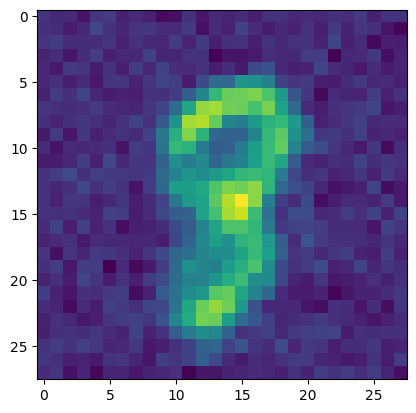

In [7]:
n_steps = 10
x = 0.1*torch.randn(1, flow.dim).to(device)
time_steps = torch.linspace(0.0, 1.0, n_steps + 1).to(device)
for i in range(n_steps):
    x = flow.step(x=x, t_start=time_steps[i], t_end=time_steps[i+1])
x = x.view(28, 28).detach().cpu().numpy()
plt.imshow(x)

# Conditional Flow

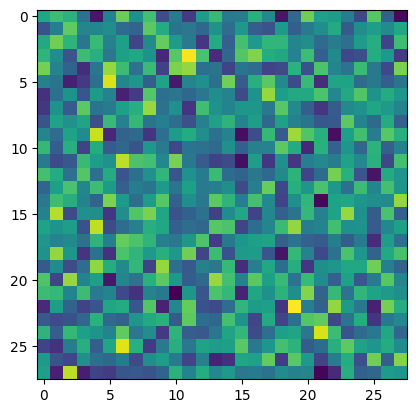

In [8]:
class CondFlow(nn.Module):
    def __init__(self, dim, h):
        super().__init__()
        self.dim = dim
        self.net = nn.Sequential(
            nn.Linear(dim + 2, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )
    
    def forward(self, t, c, x):
        return self.net(torch.cat((t, c, x), dim=-1))
    
    def step(self, x, c, t_start, t_end):
        t_start = t_start.view(1, 1).expand(x.shape[0], 1)
        t_end = t_end.view(1, 1).expand(x.shape[0], 1)
        
        t_mid = (t_end + t_start) / 2
        x_mid = x + self.forward(t=t_start, c=c, x=x) * (t_mid - t_start)
        return  x + self.forward(t=t_mid, c=c, x=x_mid) * (t_end - t_start)

model = CondFlow(784, 64).to(device)

x_0 = torch.randn(1, 784).to(device)
c = Tensor([[1.0]]).to(device)
t = torch.rand(len(x_0), 1).to(device)
x_1 = model(t, c, x_0).view(28, 28)
plt.imshow(x_1.detach().cpu().numpy())


In [9]:
def train_conditional(model, optimizer, loss_fn, epochs=2000, show_every=None, show_loss=False):
    model.train()
    losses = []
    
    if not show_every is None:
        show_loss = True
    
    for i in range(epochs):
        s = time.time()
        x_1 = dataset
        c = labels
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0], 1).to(device)

        x_t = (1 - t) * x_0 + t * x_1
        dx_t = x_1 - x_0

        v = model(t=t, c=c, x=x_t)
        loss = loss_fn(v, dx_t)
        losses.append(loss.detach().item())

        if show_loss and i % show_every == 0:
            print(f"Epoch: {i}, Loss: {losses[i]:.4f}, Time: {(time.time() - s):.2f}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses


Epoch: 0, Loss: 2.0043, Time: 0.03
Epoch: 500, Loss: 1.3149, Time: 0.02
Epoch: 1000, Loss: 1.2928, Time: 0.02
Epoch: 1500, Loss: 1.2806, Time: 0.02
Epoch: 2000, Loss: 1.2769, Time: 0.02
Epoch: 2500, Loss: 1.2721, Time: 0.02
Epoch: 3000, Loss: 1.2695, Time: 0.02
Epoch: 3500, Loss: 1.2694, Time: 0.02
Epoch: 4000, Loss: 1.2674, Time: 0.02
Epoch: 4500, Loss: 1.2673, Time: 0.02


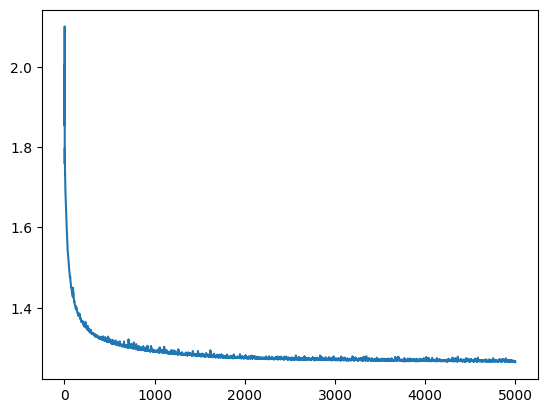

In [10]:
flow = CondFlow(28*28, 64).to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
loss = torch.nn.MSELoss()
losses = train_conditional(flow, optimizer, loss, epochs=5000, show_every=500)
plt.plot(losses)

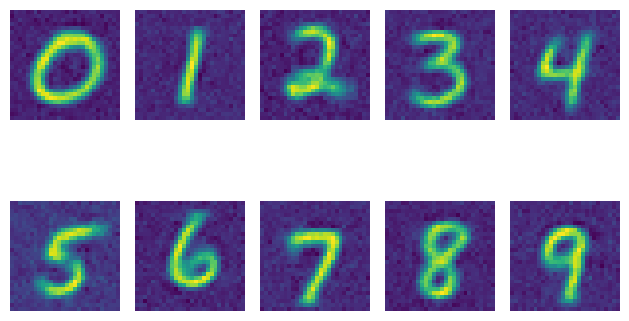

In [11]:
n_steps = 10
sigma = 0.1
x = sigma * torch.randn(10, flow.dim).to(device)
c = 0
c = Tensor([[c + (1)*i] for i in range(10)]).to(device)
# c = Tensor([[c]]*10).to(device)
time_steps = torch.linspace(0.0, 1.0, n_steps + 1).to(device)
for i in range(n_steps):
    x = flow.step(x=x, c=c, t_start=time_steps[i], t_end=time_steps[i+1])
x = x.view(-1, 28, 28).detach().cpu().numpy()

_, ax = plt.subplots(2, 5)
for i in range(10):
    ax[i//5][i%5].axis("off")
    ax[i//5][i%5].imshow(x[i])
plt.tight_layout()